In [21]:
import plotly.figure_factory as ff
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
# Load the loan dataset
df_loan = pd.read_csv(
    "https://raw.githubusercontent.com/wujenny214/Policy-Study-into-Grant-Assistance-for-Post-Hurricane-Rebuilding-Efforts/refs/heads/main/data/roadhome_for_datastore.csv"
)

/var/folders/xm/yhmrwng57qq9wlcywlm89pxh0000gn/T/ipykernel_38764/3311964682.py:2: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_loan = pd.read_csv(


In [23]:
# Load SAIPE 2004 Louisiana county-level poverty data

colspecs = [
    (0, 2),  # 1-2   FIPS State
    (3, 6),  # 4-6   FIPS County
    # (7, 15),  # 8-15  Est all ages in poverty
    # (16, 24),  # 17-24 LCI
    # (25, 33),  # 26-33 UCI
    (34, 38),  # 35-38 % all ages est
    # (39, 43),  # 40-43 % all ages LCI
    # (44, 48),  # 45-48 % all ages UCI
    # (49, 57),  # 50-57 Est age 0-17
    # (58, 66),  # 59-66 LCI
    # (67, 75),  # 68-75 UCI
    # (76, 80),  # 77-80 % 0-17 est
    # (81, 85),  # 82-85 % 0-17 LCI
    # (86, 90),  # 87-90 % 0-17 UCI
    # (91, 99),  # 92-99 Est related children 5-17 in families
    # (100, 108),  # 101-108 LCI
    # (109, 117),  # 110-117 UCI
    # (118, 122),  # 119-122 % related 5-17 est
    # (123, 127),  # 124-127 % related 5-17 LCI
    # (128, 132),  # 129-132 % related 5-17 UCI
    # (133, 139),  # 134-139 Median HH income
    # (140, 146),  # 141-146 Median HH income LCI
    # (147, 153),  # 148-153 Median HH income UCI
    # (154, 161),  # Estimate of people under age 5 in poverty
    # (162, 169),  # 90% confidence interval lower bound of estimate of people under age 5 in poverty
    # (170, 177),  # 90% confidence interval upper bound of estimate of people under age 5 in poverty
    # (178, 182),  # Estimated percent of people under age 5 in poverty
    # (183, 187),  # 90% confidence interval lower bound of estimate of percent of people under age 5 in poverty
    # (189, 192),  # 90% confidence interval upper bound of estimate of percent of people under age 5 in poverty
    (193, 238),  # State or county name
    # (239, 241),  # Two-letter Postal State abbreviation
    # (242, 266),  # A tag indicating the file name and date of creation
]

names = [
    "state_fips",
    "county_fips",
    # "all_ages_pov_est",
    # "all_ages_pov_l",
    # "all_ages_pov_u",
    "all_ages_pov_pct_est",
    # "all_ages_pov_pct_l",
    # "all_ages_pov_pct_u",
    # "age0_17_pov_est",
    # "age0_17_pov_l",
    # "age0_17_pov_u",
    # "age0_17_pov_pct_est",
    # "age0_17_pov_pct_l",
    # "age0_17_pov_pct_u",
    # "rel5_17_pov_est",
    # "rel5_17_pov_l",
    # "rel5_17_pov_u",
    # "rel5_17_pov_pct_est",
    # "rel5_17_pov_pct_l",
    # "rel5_17_pov_pct_u",
    # "med_hh_income_est",
    # "med_hh_income_l",
    # "med_hh_income_u",
    # "est_ppl_under5pov",
    # "lci_ppl_under5pov",
    # "uci_ppl_under5pov",
    # "pct_ppl_under5pov_est",
    # "pct_ppl_under5pov_l",
    # "pct_ppl_under5pov_u",
    "parish",
    # "state",
    # "file_tag",
]

# Read the fixed-width file
url = "https://www2.census.gov/programs-surveys/saipe/datasets/2004/2004-state-and-county/est04-la.txt"
df_poverty = pd.read_fwf(url, colspecs=colspecs, names=names, dtype=str)

# Construct the FIPS codes directly and save them into the dataframe
df_poverty["FIPS"] = df_poverty.apply(
    lambda row: row["state_fips"]
    + ("00" if len(row["county_fips"]) == 1 else "0")
    + row["county_fips"],
    axis=1,
)

# # (ALT method) Initialize an empty list to store the FIPS codes
# fips_codes = []

# # Iterate through each row in the dataframe
# for i, row in df_poverty.iterrows():
#     # Check the length of the county_fips and construct the FIPS code accordingly
#     if len(row["county_fips"]) == 1:
#         fips_code = row["state_fips"] + "00" + row["county_fips"]
#     else:
#         fips_code = row["state_fips"] + "0" + row["county_fips"]
#     fips_codes.append(fips_code)

# # Add the constructed FIPS codes as a new column in the dataframe
# df_poverty["FIPS"] = fips_codes

df_poverty = df_poverty[["FIPS", "parish", "all_ages_pov_pct_est"]].copy()
df_poverty = df_poverty[1:]
df_poverty.head()

,FIPS,parish,all_ages_pov_pct_est
1,22001,Acadia Parish,21.0
2,22003,Allen Parish,22.0
3,22005,Ascension Parish,12.0
4,22007,Assumption Parish,19.3
5,22009,Avoyelles Parish,24.8


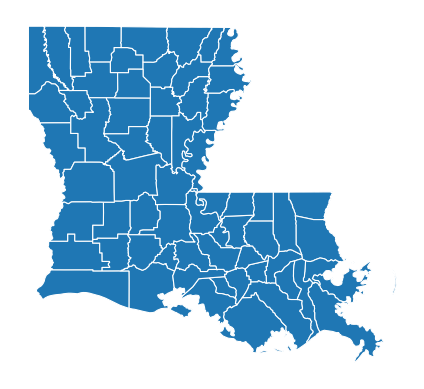

In [24]:
# Download all US counties (2023, 1:5m cartographic boundaries) from Census
url = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_county_5m.zip"
counties = gpd.read_file(url)

# Keep only Louisiana (STATEFP = '22')
la = counties[counties["STATEFP"] == "22"].copy()

# Keep useful fields; GEOID is the full 5-digit county/parish FIPS
la = la[["GEOID", "STATEFP", "COUNTYFP", "NAME", "geometry"]]

# Save as GeoJSON (Leaflet/Mapbox/Folium/Plotly-ready)
la.to_file("louisiana_counties_fips.geojson", driver="GeoJSON")

# Mapping Louisiana parishes
ax = la.plot(edgecolor="white", linewidth=0.8)
ax.set_axis_off()

In [28]:
# Merging poverty data with Louisiana parishes geodataframe
la_poverty = la.merge(df_poverty, left_on="GEOID", right_on="FIPS", how="left")
la_poverty["all_ages_pov_pct_est"] = pd.to_numeric(
    la_poverty["all_ages_pov_pct_est"], errors="coerce"
)
la_poverty.head()

,GEOID,STATEFP,COUNTYFP,NAME,geometry,FIPS,parish,all_ages_pov_pct_est
0,22061,22,061,Lincoln,"POLYGON ((-92.88093 32.58526, -92.86661 32.607...",22061,Lincoln Parish,22.6
1,22095,22,095,St. John the Baptist,"POLYGON ((-90.68727 30.0372, -90.66997 30.0476...",22095,St. John the Baptist Parish,16.4
2,22029,22,029,Concordia,"POLYGON ((-91.8633 31.35445, -91.84502 31.3759...",22029,Concordia Parish,25.6
3,22003,22,003,Allen,"POLYGON ((-93.13119 30.51828, -93.13081 30.564...",22003,Allen Parish,22.0
4,22093,22,093,St. James,"POLYGON ((-90.96374 30.06683, -90.93559 30.085...",22093,St. James Parish,17.7


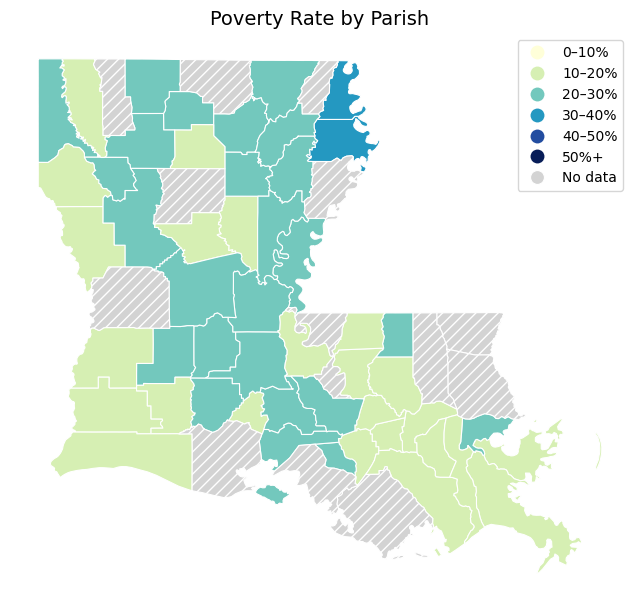

In [29]:
# Create bins manually
bins = [0, 10, 20, 30, 40, 50, 100]
labels = ["0–10%", "10–20%", "20–30%", "30–40%", "40–50%", "50%+"]

la_poverty["pov_bin"] = pd.cut(
    la_poverty["all_ages_pov_pct_est"], bins=bins, labels=labels, include_lowest=True
)

# Plot with grey for missing
fig, ax = plt.subplots(figsize=(8, 8))
la_poverty.plot(
    column="pov_bin",
    cmap="YlGnBu",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    },
)
ax.set_title("Poverty Rate by Parish", fontsize=14)
ax.axis("off")
plt.show()